In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import grader

# The New York Social Graph

[New York Social Diary](http://www.newyorksocialdiary.com/) provides a
fascinating lens onto New York's socially well-to-do.  The data forms a natural social graph for New York's social elite.  Take a look at this page of a recent [run-of-the-mill holiday party](http://www.newyorksocialdiary.com/party-pictures/2014/holiday-dinners-and-doers).

Besides the brand-name celebrities, you will notice the photos have carefully annotated captions labeling those that appear in the photos.  We can think of this as implicitly implying a social graph: there is a connection between two individuals if they appear in a picture together.

For this project, we will assemble the social graph from photo captions for parties dated December 1, 2014, and before.  Using this graph, we can make guesses at the most popular socialites, the most influential people, and the most tightly coupled pairs.

We will attack the project in three phases:
1. Get a list of all the photo pages to be analyzed.
2. Parse all of the captions on a sample page.
3. Parse all of the captions on all pages, and assemble the graph.

## Phase One

The first step is to crawl the data.  We want photos from parties on or before December 1st, 2014.  Go to the [Party Pictures Archive](http://www.newyorksocialdiary.com/party-pictures) to see a list of (party) pages.  We want to get the url for each party page, along with its date.

Here are some packagest that you may find useful.  You are welcome to use others, if you prefer.

In [3]:
import requests
import dill
from bs4 import BeautifulSoup
from datetime import datetime

We recommend using Python [Requests](http://docs.python-requests.org/en/master/) to download the HTML pages, and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) to process the HTML.  Let's start by getting the [first page](http://www.newyorksocialdiary.com/party-pictures).

In [ ]:
page = ... # Use requests.get to download the page.

Now, we process the text of the page with BeautifulSoup.

In [ ]:
soup = BeautifulSoup(page.text, "lxml")

This page has links to 50 party pages. Look at the structure of the page and determine how to isolate those links.  Your browser's developer tools (usually `Cmd`-`Option`-`I` on Mac, `Ctrl`-`Shift`-`I` on others) offer helpful tools to explore the structure of the HTML page.

Once you have found a patter, use BeautifulSoup's [select](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#css-selectors) or [find_all](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find) methods to get those elements.

In [ ]:
links = ...

There should be 50 per page.

In [ ]:
assert len(links) == 50

Let's take a look at that first link.  Figure out how to extract the URL of the link, as well as the date.  You probably want to use `datetime.strptime`.  See the [format codes for dates](https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior) for reference.

In [ ]:
link = links[0]
# Check that the title and date match what you see visually.

For purposes of code reuse, let's put that logic into a function.  It should take the link element and return the URL and date parsed from it.

In [ ]:
def get_link_date(el):
    ...
    return url, date

You may want to check that it works as you expected.

Once that's working, let's write another function to parse all of the links on a page.  Thinking ahead, we can make it take a Requests [Response](http://docs.python-requests.org/en/master/api/#requests.Response) object and do the BeautifulSoup parsing within it.

In [ ]:
def get_links(response):
    return ... # A list of URL, date pairs

If we run this on the previous response, we should get 50 pairs.

In [ ]:
assert len(get_links(page)) == 50

But we only want parties with dates on or before the first of December, 2014.  Let's write a function to filter our list of dates to those at or before a cutoff.  Using a keyword argument, we can put in a default cutoff, but allow us to test with others.

In [ ]:
def filter_by_date(links, cutoff=datetime(2014, 12, 1)):
    # Return only the elements with date <= cutoff

With the default cutoff, there should be no valid parties on the first page.  Adjust the cutoff date to check that it is actually working.

In [ ]:
assert len(filter_by_date(get_links(page))) == 0

Now we should be ready to get all of the party URLs.  Click through a few of the index pages to determine how the URL changes.  Figure out a strategy to visit all of them.

HTTP requests are generally IO-bound.  This means that most of the time is spent waiting for the remote server to respond.  If you use `requests` directly, you can only wait on one response at a time.  [requests-futures](https://github.com/ross/requests-futures) lets you wait for multiple requests at a time.  You may wish to use this to speed up the downloading process.

In [ ]:
from requests_futures.sessions import FuturesSession

link_list = []
# You can use link_list.extend(others) to add the elements of others
# to link_list.

In the end, you should have 1193 parties.

In [ ]:
assert len(link_list) == 1193

In case we need to restart the notebook, we should save this information to a file.  There are many ways you could do this; here's one using `dill`.

In [ ]:
dill.dump(link_list, open('nysd-links.pkd', 'w'))

To restore the list, we can just load it from the file.  When the notebook is restarted, you can skip the code above and just run this command.

In [ ]:
link_list = dill.load(open('nysd-links.pkd', 'r'))

## Question 1: histogram

Get the number of party pages for the 95 months (that is, month-year pair) in the data.  Notice that while the party codes might be written as "FRIDAY, FEBRUARY 28, 2014", in this output, you would have to represent the month-year code as "Feb-2014".  This can all be done with `strfime` and the [format codes for dates](https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior).

Plot the histogram for yourself.  Do you see any trends?

In [9]:
### Solution
import requests
import dill
from bs4 import BeautifulSoup
from datetime import datetime
from itertools import compress
import pandas as pd
import numpy as np
def get_links():
    result = pd.DataFrame(np.random.randn(1414,2), columns = ['website','date'])
    for j in range(29):
        page = requests.get('http://www.newyorksocialdiary.com/party-pictures?page=%s' % (j), auth=('user', 'pass'))
        soup = BeautifulSoup(page.text, "lxml")
        for i,section in enumerate(soup.findAll("span",{"class":"field-content"})):
            # link = section.find_all("a",text="party-pictures")
            # tt = list(link)
            # test = section['href']
            temp_str = str(section)
            index = (100*j+i)/2
            if i%2 == 0:
                sep = "\">"
                result.iloc[index,0] = temp_str[37:-11].split(sep,1)[0]
                # result.iloc[index,0] = temp_str[36:-11]
            else:
                result.iloc[index,1] = temp_str[28:-7]
    return result

def histogram():
    url_date = get_links()
    url_date['month_date'] = pd.to_datetime(url_date.loc[:,'date']).dt.strftime('%b-%Y')
    count = url_date.loc[219:,'month_date'].value_counts(sort=False)
    l_1 = [x.encode('utf-8') for x in count.index]
    l_2 = count.tolist()
    test = zip(l_1,l_2)
    return test
count = histogram()

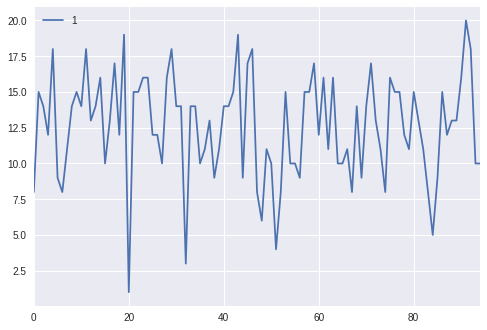

In [12]:
# Sanity check
pd.DataFrame(count).plot()

In [ ]:
### Grade
'''
def histogram():
    return [("Dec-2014", 1)] * 95  # Replace with the correct list

'''

grader.score(question_name='graph__histogram', func=histogram)

## Phase Two

In this phase, we we concentrate on getting the names out of captions for a given page.  We'll start with [the benefit cocktails and dinner](http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood) for [Lenox Hill Neighborhood House](http://www.lenoxhill.org/), a neighborhood organization for the East Side.

Take a look at that page.  Note that some of the text on the page is captions, but others are descriptions of the event.  Determine how to select only the captions.

In [ ]:
captions = ...

By our count, there are about 110.  But if you're off by a couple, you're probably okay.

In [ ]:
assert abs(len(captions) - 110) < 5

Let's encapsulate this in a function.  As with the links pages, we want to avoid downloading a given page the next time we need to run the notebook.  While we could save the files by hand, as we did before, a checkpointing library like [ediblepickle](https://pypi.python.org/pypi/ediblepickle/1.1.3) can handle this for you.  (Note, though, that you may not want to enable this until you are sure that your function is working.)

You should also keep in mind that HTTP requests fail occasionally, for transient reasons.  You should plan how to detect and react to these failures.   The [retrying module](https://pypi.python.org/pypi/retrying) is one way to deal with this.

In [ ]:
def get_captions(path):
    ...

This should get the same captions as before.

In [ ]:
assert captions == get_captions("/party-pictures/2015/celebrating-the-neighborhood")

Now that we have some sample captions, let's start parsing names out of those captions.  There are many ways of going about this, and we leave the details up to you.  Some issues to consider:

  1. Some captions are not useful: they contain long narrative texts that explain the event.  Try to find some heuristic rules to separate captions that are a list of names from those that are not.  A few heuristics include:
    - look for sentences (which have verbs) and as opposed to lists of nouns. For example, [nltk does part of speech tagging](http://www.nltk.org/book/ch05.html) but it is a little slow. There may also be heuristics that accomplish the same thing.
    - Similarly, spaCy's [entity recognition](https://spacy.io/docs/usage/entity-recognition) couble be useful here.
    - Look for commonly repeated threads (e.g. you might end up picking up the photo credits or people such as "a friend").
    - Long captions are often not lists of people.  The cutoff is subjective, but for grading purposes, *set that cutoff at 250 characters*.
  2. You will want to separate the captions based on various forms of punctuation.  Try using `re.split`, which is more sophisticated than `string.split`. **Note**: The reference solution uses regex exclusively for name parsing.
  3. You might find a person named "ra Lebenthal".  There is no one by this name.  Can anyone spot what's happening here?
  4. This site is pretty formal and likes to say things like "Mayor Michael Bloomberg" after his election but "Michael Bloomberg" before his election.  Can you find other ('optional') titles that are being used?  They should probably be filtered out because they ultimately refer to the same person: "Michael Bloomberg."
  5. There is a special case you might find where couples are written as eg. "John and Mary Smith". You will need to write some extra logic to make sure this properly parses to two names: "John Smith" and "Mary Smith".
  6. When parsing names from captions, it can help to look at your output frequently and address the problems that you see coming up, iterating until you have a list that looks reasonable. This is the approach used in the reference solution. Because we can only asymptotically approach perfect identification and entity matching, we have to stop somewhere.
  
**Questions worth considering:**
  1. Who is Patrick McMullan and should he be included in the results? How would you address this?
  2. What else could you do to improve the quality of the graph's information?

## Question 2: sample_names

Once you feel that your algorithm is working well on these captions, parse all of the captions and extract all the names mentioned.  Sort them alphabetically, by first name, and return the first hundred.

In [65]:
### Solution
import spacy
page = requests.get('http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood', auth=('user', 'pass'))
soup = BeautifulSoup(page.text, "lxml")
# print(page)
# print soup.prettify()

def names():
    name_list = []
    temp_name = []
    for section in soup.findAll("div",{"class":"photocaption"}):
        name = str(section)[41:-6].decode('utf-8').strip()
        name_list.append(name)

    # print(name_list)
    nlp = spacy.load('en')
    for i in range(len(name_list)):
        doc = nlp(name_list[i])
        for ent in doc.ents:
            if len(ent.text.split())!=1: # this is used to deal with ohn and Mary Smith problem: don't include the single first name one
                temp_name.append(''.join(ent.text.split('<br/',1)))
    final_name_list = [i.encode('utf-8') for i in temp_name]
    final_name_list = list(set(final_name_list))
    final_name_list.sort()
    return final_name_list[1:101]
name_output = names()

In [70]:
### Sanity Check
name_output[0:5]


['Alex Papachristidis',
 'Alexandra Richards',
 'Alexis Mersentes',
 'Allen Swerdlick',
 'Allison Minton']

In [68]:
### Grade

def sample_names():
    return name_output

grader.score(question_name='graph__sample_names', func=sample_names)

Your score:  1.0


Now, run this sort of test on a few other pages.  You will probably find that other pages have a slightly different HTML structure, as well as new captions that trip up your caption parser.  But don't worry if the parser isn't perfect -- just try to get the easy cases.

## Phase Three

Once you are satisfied that your caption scraper and parser are working, run this for all of the pages.  If you haven't implemented some caching of the captions, you probably want to do this first.

In [ ]:
# Scraping all of the pages could take 10 minutes or so.

For the remaining analysis, we think of the problem in terms of a
[network](http://en.wikipedia.org/wiki/Computer_network) or a
[graph](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29).  Any time a pair of people appear in a photo together, that is considered a link.  What we have described is more appropriately called an (undirected)
[multigraph](http://en.wikipedia.org/wiki/Multigraph) with no self-loops but this has an obvious analog in terms of an undirected [weighted graph](http://en.wikipedia.org/wiki/Graph_%28mathematics%29#Weighted_graph).  In this problem, we will analyze the social graph of the new york social elite.  We recommend using python's [networkx](https://networkx.github.io/) library.

In [ ]:
import itertools  # itertools.combinations may be useful
import networkx as nx

All in all, you should end up with over 100,000 captions and more than 110,000 names, connected in about 200,000 pairs.

## Question 3: degree

The simplest question to ask is "who is the most popular"?  The easiest way to answer this question is to look at how many connections everyone has.  Return the top 100 people and their degree.  Remember that if an edge of the graph has weight 2, it counts for 2 in the degree.

**Checkpoint:** Some aggregate stats on the solution

    "count": 100.0
    "mean": 189.92
    "std": 87.8053034454
    "min": 124.0
    "25%": 138.0
    "50%": 157.0
    "75%": 195.0
    "max": 666.0

In [ ]:
import heapq  # Heaps are efficient structures for tracking the largest
              # elements in a collection.  Use introspection to find the
              # function you need.
def degree():
    return [('Alec Baldwin', 144)] * 100

grader.score(question_name='graph__degree', func=degree)

## Question 4: pagerank

A similar way to determine popularity is to look at their
[pagerank](http://en.wikipedia.org/wiki/PageRank).  Pagerank is used for web ranking and was originally
[patented](http://patft.uspto.gov/netacgi/nph-Parser?patentnumber=6285999) by Google and is essentially the stationary distribution of a [markov
chain](http://en.wikipedia.org/wiki/Markov_chain) implied by the social graph.

Use 0.85 as the damping parameter so that there is a 15% chance of jumping to another vertex at random.

**Checkpoint:** Some aggregate stats on the solution

    "count": 100.0
    "mean": 0.0001841088
    "std": 0.0000758068
    "min": 0.0001238355
    "25%": 0.0001415028
    "50%": 0.0001616183
    "75%": 0.0001972663
    "max": 0.0006085816

In [ ]:
def pagerank():
    return [('Martha Stewart', 0.00019312108706213307)] * 100

grader.score(question_name='graph__pagerank', func=pagerank)

## Question 5: best_friends

Another interesting question is who tend to co-occur with each other.  Give us the 100 edges with the highest weights.

Google these people and see what their connection is.  Can we use this to detect instances of infidelity?

**Checkpoint:** Some aggregate stats on the solution

    "count": 100.0
    "mean": 25.84
    "std": 16.0395470855
    "min": 14.0
    "25%": 16.0
    "50%": 19.0
    "75%": 29.25
    "max": 109.0

In [ ]:
def best_friends():
    return [(('Michael Kennedy', 'Eleanora Kennedy'), 41)] * 100

grader.score(question_name='graph__best_friends', func=best_friends)

*Copyright &copy; 2016 The Data Incubator.  All rights reserved.*